# Manual temporal GNN using PyG

## Data generation code

In [20]:
import torch
from torch_geometric.data import Data, Dataset

class PouchTemporalDataset_weight(Dataset):
    def __init__(self, Ca, edge_index, edge_weight):
        """
        Ca: numpy array, shape (N, T)
        edge_index: torch.LongTensor, shape (2, E)
        """
        super().__init__()
        self.Ca = torch.tensor(Ca, dtype=torch.float)      # (N, T)
        self.edge_index = edge_index
        self.edge_weight = edge_weight
        self.T = Ca.shape[1]

    def len(self):
        # One data point per (t -> t+1)
        return self.T - 1

    def get(self, idx):
        # x = Ca at time t
        x = self.Ca[:, idx].unsqueeze(1)      # (N, 1)
        # y = Ca at time t+1
        y = self.Ca[:, idx+1].unsqueeze(1)    # (N, 1)

        return Data(
            x=x,
            y=y,
            edge_index=self.edge_index,
            edge_weight=self.edge_weight
        )


## GConv -> GRU -> Linear Model

In [26]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv

class GCN_GRU_Surrogate(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()

        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, hidden_channels)

        self.norm = nn.LayerNorm(hidden_channels)
        self.gru = nn.GRU(hidden_channels, hidden_channels, batch_first=False)

        self.lin = nn.Linear(hidden_channels, 1)
        self.hidden_channels = hidden_channels

    def forward(self, x_t, edge_index, edge_weight, h):
        # Spatial step
        g = torch.relu(self.gcn1(x_t, edge_index, edge_weight))
        g = self.gcn2(g, edge_index, edge_weight)
        g = self.norm(g)

        # Temporal step
        g_seq = g.unsqueeze(0)           # (1, N, H)
        out, h_new = self.gru(g_seq, h)  # (1, N, H)

        # Predict next state
        pred = self.lin(out.squeeze(0))  # (N,1)
        return pred, h_new

    def init_hidden(self, N):
        return torch.zeros(1, N, self.hidden_channels)


## Training Loop

In [27]:
def train_model2(model, dataset, epochs=50, lr=1e-3):
    loader = DataLoader(dataset, batch_size=1, shuffle=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    N = dataset.Ca.shape[0]

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        h = model.init_hidden(N)

        for data in loader:
            x = data.x
            y = data.y
            edge_index = data.edge_index
            edge_weight = data.edge_weight

            # Forward
            pred, h = model(x, edge_index, edge_weight, h)

            # ⛔ CRITICAL: Detach hidden state so graph doesn't grow across timesteps
            h = h.detach()

            # Compute loss
            loss = loss_fn(pred, y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch}: Loss = {total_loss:.6f}")

## Autoregressive Rollout for Testing

In [28]:
def autoregressive_rollout(model, x0, edge_index, edge_weight, steps=200):
    """
    x0: (N,1) initial Ca frame
    """
    model.eval()

    N = x0.shape[0]
    h = model.init_hidden(N)

    x_t = x0
    preds = [x0.detach().cpu().numpy()]

    for _ in range(steps):
        x_next, h = model(x_t, edge_index, edge_weight, h)
        preds.append(x_next.detach().cpu().numpy())
        x_t = x_next

    # returns array (steps+1, N, 1)
    return np.stack(preds, axis=1)


# Pipeline

## Load a simulation output

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

ca_models_lib_mac = "/Users/scini/Documents/GitHub/Systems_Bio/ca_models_lib.py" 
ca_models_lib_path = ca_models_lib_mac  # Change this if on a different system

# Add the directory containing ca_models_lib.py to sys.path
import sys
import os
if ca_models_lib_path not in sys.path:
    sys.path.append(os.path.dirname(ca_models_lib_path))

import ca_models_lib as caml

import pandas as pd
import time


In [10]:
# Load data
folder_path_pc = r"C:\Users\steph\Box\ZartmanLabGroupFolder\Zartman_Dowling\Stephen\MC2021_Data"
folder_path_mac = r"/Users/scini/Library/CloudStorage/Box-Box/ZartmanLabGroupFolder/Zartman_Dowling/Stephen/MC2021_Data"

folder_path = folder_path_mac
# Get geometry files

# Select size
size = 'xsmall'  # Options: 'xsmall', 'small', 'medium', 'large',
# Load statics for wing disc geometries    
disc_vertices = np.load(os.path.join(folder_path, "geometry", "disc_vertices.npy"), allow_pickle=True).item()  # Vertices
disc_laplacians = np.load(os.path.join(folder_path, "geometry", "disc_sizes_laplacian.npy"), allow_pickle=True).item()  # Laplacian Matrix
disc_adjs = np.load(os.path.join(folder_path, "geometry", "disc_sizes_adj.npy"), allow_pickle=True).item()  # Adjacency matrix

adj_matrix=disc_adjs[size] # Adjacency Matrix
laplacian_matrix=disc_laplacians[size] # Laplacian Matrix
new_vertices=disc_vertices[size] # Vertices

# Number of cells
num_cells = new_vertices.shape[0]

In [11]:
disc_model_dense = caml.PouchModelScipy_dense(laplacian_matrix, sim_time=3600, dt=1, 
                                              t_eval_boolean=True, random_seed=123456  
                                              ) 

In [12]:
t_sim = time.perf_counter()
sig2 = disc_model_dense.simulate()
print(f"Step 2 took {time.perf_counter() - t_sim:.4f} seconds")

Step 2 took 31.4236 seconds


In [13]:
stim_cells2 = disc_model_dense.stimulated_cell_idxs

print(stim_cells2)

[175  66 173]


In [14]:
# print(Ca_conc.shape, IP3_conc.shape, R_conc.shape)
time_points2 = sig2.t
Ca_conc2 = sig2.y[:num_cells, :]
IP3_conc2 = sig2.y[num_cells:2*num_cells, :]
R_conc2 = sig2.y[2*num_cells:, :]

print(Ca_conc2.shape, IP3_conc2.shape, R_conc2.shape)

(195, 3600) (195, 3600) (195, 3600)


In [15]:
# Add 1% Gaussian noise
np.random.seed(123456)  # For reproducibility
Ca_conc2_noisy = Ca_conc2 + np.random.normal(0, 0.01 * np.std(Ca_conc2), Ca_conc2.shape)

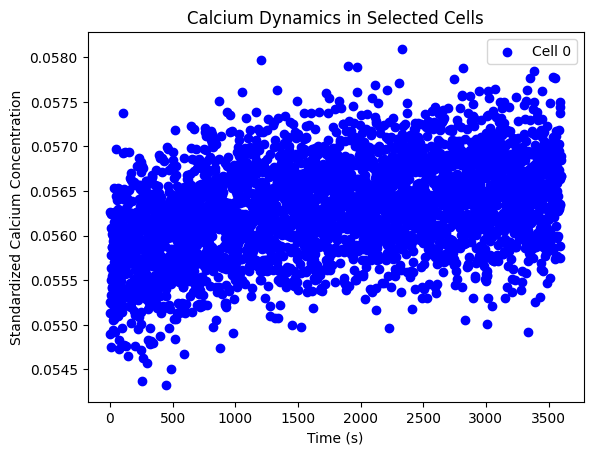

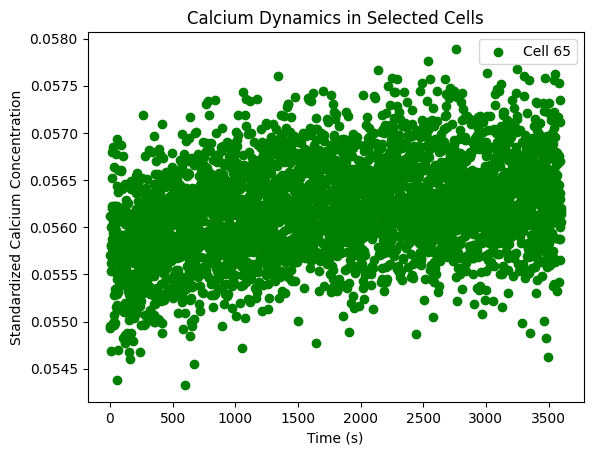

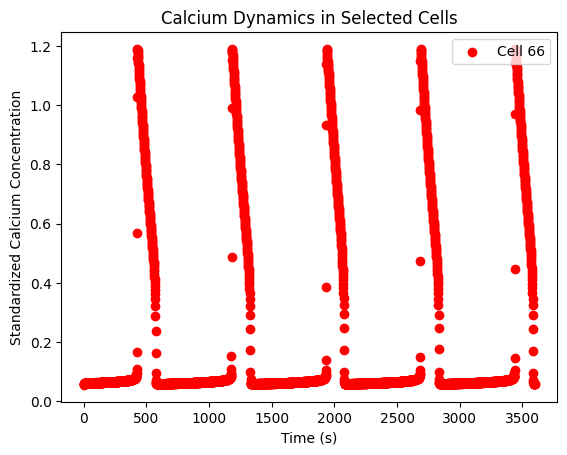

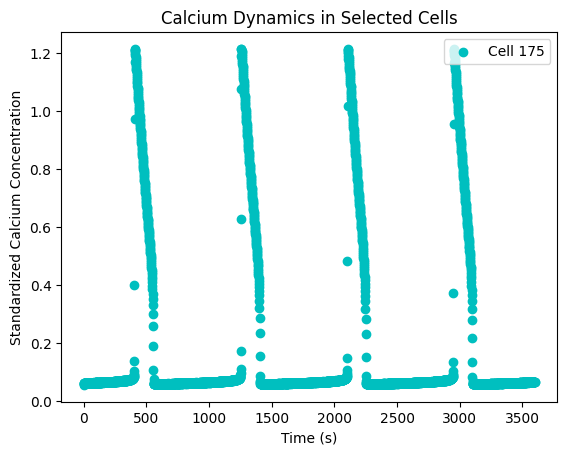

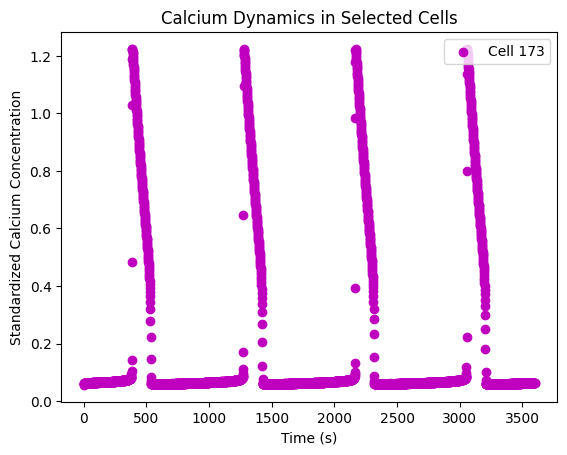

In [16]:
# Plot a few example cells to visualize the calcium dynamics

cell_indices = [0, 65, 66, 175 ,173 ]  # Example cell indices
colors = ['b', 'g', 'r', 'c', 'm']
for i in cell_indices:
    plt.scatter(time_points2[1:], Ca_conc2_noisy[i, 1:], label=f'Cell {i}', color=colors[cell_indices.index(i) % len(colors)])
    plt.xlabel('Time (s)')
    plt.ylabel('Standardized Calcium Concentration')
    plt.title('Calcium Dynamics in Selected Cells')
    plt.legend()
    plt.show()


In [17]:
off_diag_lap = laplacian_matrix - np.diag(np.diag(laplacian_matrix))
display(off_diag_lap)

is_symmetric = np.allclose(off_diag_lap, off_diag_lap.T)
print("Symmetric?", is_symmetric)

row, col = np.nonzero(off_diag_lap)
# np.array(row)
# np.array(col)

edge_index = torch.tensor([row, col], dtype=torch.long)
print(edge_index)
print(edge_index.shape)  # Should be [2, num_edges]
edge_weight = torch.tensor(off_diag_lap[row, col], dtype=torch.float32)


print(edge_weight)
print(edge_weight.shape)  # Should be [num_edges,]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 10.19337977],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., 10.19337977,
         0.        ,  0.        ]], shape=(195, 195))

Symmetric? True
tensor([[  0,   0,   1,  ..., 194, 194, 194],
        [  3,   5,   3,  ..., 188, 189, 192]])
torch.Size([2, 1064])
tensor([ 8.6643,  9.5087,  8.8120,  ...,  8.8206,  7.3286, 10.1934])
torch.Size([1064])


/var/folders/v2/s6clf_y12bjd0pq98kr66skw0000gs/T/ipykernel_79356/737813101.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1724788636709/work/torch/csrc/utils/tensor_new.cpp:281.)
  edge_index = torch.tensor([row, col], dtype=torch.long)


In [24]:
# Build PouchTemporalDataset
dataset = PouchTemporalDataset_weight(Ca_conc2_noisy, edge_index, edge_weight)

In [30]:
# Make the model and train it
model = GCN_GRU_Surrogate(in_channels=1, hidden_channels=32)
train_model2(model, dataset, epochs=50, lr=1e-3)

Epoch 0: Loss = 2.885481
Epoch 1: Loss = 1.310410
Epoch 2: Loss = 0.689072
Epoch 3: Loss = 0.570046
Epoch 4: Loss = 0.662134
Epoch 5: Loss = 0.324565
Epoch 6: Loss = 0.408414
Epoch 7: Loss = 0.261736
Epoch 8: Loss = 0.204626
Epoch 9: Loss = 0.238757
Epoch 10: Loss = 0.182461
Epoch 11: Loss = 0.125785
Epoch 12: Loss = 0.192078
Epoch 13: Loss = 0.181151
Epoch 14: Loss = 0.233298
Epoch 15: Loss = 0.179837
Epoch 16: Loss = 0.160201
Epoch 17: Loss = 0.116326
Epoch 18: Loss = 0.114934
Epoch 19: Loss = 0.121941
Epoch 20: Loss = 0.141149
Epoch 21: Loss = 0.150458
Epoch 22: Loss = 0.125187
Epoch 23: Loss = 0.145788
Epoch 24: Loss = 0.242342
Epoch 25: Loss = 0.164435
Epoch 26: Loss = 0.384442
Epoch 27: Loss = 0.477696
Epoch 28: Loss = 0.151960
Epoch 29: Loss = 0.379590
Epoch 30: Loss = 0.158361
Epoch 31: Loss = 0.143563
Epoch 32: Loss = 0.250429
Epoch 33: Loss = 0.331189
Epoch 34: Loss = 0.293360
Epoch 35: Loss = 0.155392
Epoch 36: Loss = 0.198059
Epoch 37: Loss = 0.130581
Epoch 38: Loss = 0.337

In [32]:
# Autoregressive rollout
x0 = torch.tensor(Ca_conc2_noisy[:, 0]).unsqueeze(1).float()  # (N,1)
preds = autoregressive_rollout(model, x0, edge_index, edge_weight, steps=Ca_conc2_noisy.shape[1]-1)

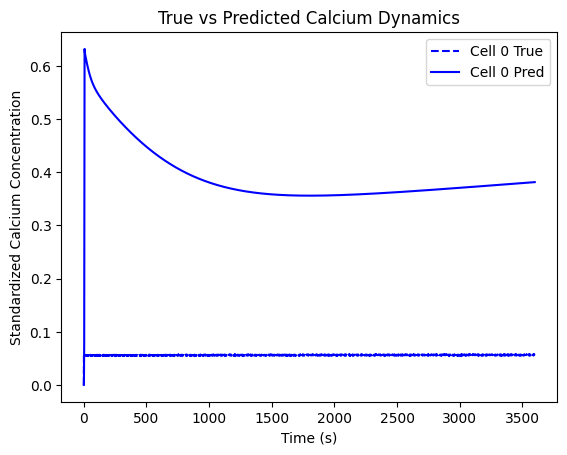

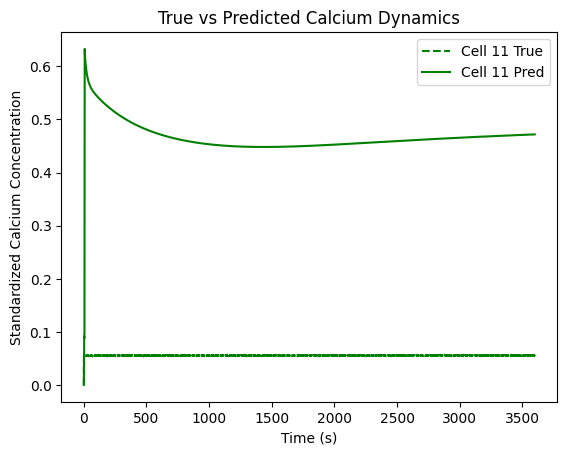

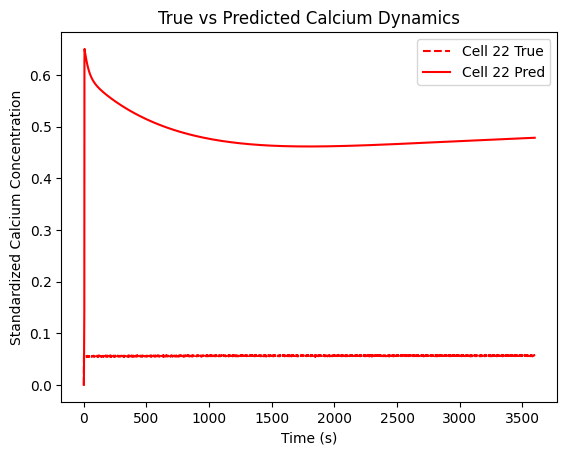

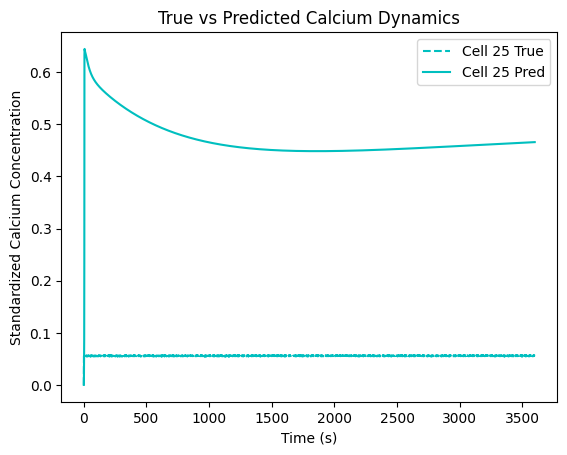

In [33]:
# Plot results for a few example cells
cell_indices = [0, 11, 22, 25 ]  #Example cell indices
colors = ['b', 'g', 'r', 'c', 'm']
for i in cell_indices:
    plt.plot(time_points2, Ca_conc2_noisy[i, :], label=f'Cell {i} True', color=colors[cell_indices.index(i) % len(colors)], linestyle='--')
    plt.plot(time_points2, preds[i, :, 0], label=f'Cell {i} Pred', color=colors[cell_indices.index(i) % len(colors)], linestyle='-')
    plt.xlabel('Time (s)')
    plt.ylabel('Standardized Calcium Concentration')
    plt.title('True vs Predicted Calcium Dynamics')
    plt.legend()
    plt.show()

## Normal training, no autoregression

In [34]:
def train_model_nextstep(model, dataset, epochs=50, lr=1e-3):
    loader = DataLoader(dataset, batch_size=1, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    N = dataset.Ca.shape[0]   # number of nodes/cells

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        for data in loader:

            x = data.x          # (N,1)
            y = data.y          # (N,1)
            edge_index = data.edge_index
            edge_weight = data.edge_weight

            # Reset hidden state EVERY time
            h = model.init_hidden(N)

            pred, h = model(x, edge_index, edge_weight, h)

            loss = loss_fn(pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch}: loss = {total_loss:.6f}")


In [35]:
def evaluate_nextstep(model, dataset):
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    model.eval()

    N = dataset.Ca.shape[0]
    preds, truths = [], []

    with torch.no_grad():
        for data in loader:
            x = data.x
            y = data.y
            edge_index = data.edge_index
            edge_weight = data.edge_weight

            h = model.init_hidden(N)    # reset!
            pred, h = model(x, edge_index, edge_weight, h)

            preds.append(pred.cpu())
            truths.append(y.cpu())

    return preds, truths

In [38]:
T_train = 3000
Ca = Ca_conc2_noisy

train_set = PouchTemporalDataset_weight(Ca[:, :T_train], edge_index ,edge_weight)
test_set  = PouchTemporalDataset_weight(Ca[:, T_train-1:], edge_index, edge_weight)

In [39]:
# Train next-step model
model_nextstep = GCN_GRU_Surrogate(in_channels=1, hidden_channels=32)
train_model_nextstep(model_nextstep, train_set, epochs=50, lr=1e-3)


Epoch 0: loss = 1.848187
Epoch 1: loss = 0.326157
Epoch 2: loss = 0.221005
Epoch 3: loss = 0.181411
Epoch 4: loss = 0.174888
Epoch 5: loss = 0.203231
Epoch 6: loss = 0.165584
Epoch 7: loss = 0.148742
Epoch 8: loss = 0.155682
Epoch 9: loss = 0.144247
Epoch 10: loss = 0.145840
Epoch 11: loss = 0.135925
Epoch 12: loss = 0.134923
Epoch 13: loss = 0.134096
Epoch 14: loss = 0.130120
Epoch 15: loss = 0.131323
Epoch 16: loss = 0.124986
Epoch 17: loss = 0.133393
Epoch 18: loss = 0.123045
Epoch 19: loss = 0.126635
Epoch 20: loss = 0.122789
Epoch 21: loss = 0.121496
Epoch 22: loss = 0.124860
Epoch 23: loss = 0.116235
Epoch 24: loss = 0.120002
Epoch 25: loss = 0.117664
Epoch 26: loss = 0.118893
Epoch 27: loss = 0.115547
Epoch 28: loss = 0.113351
Epoch 29: loss = 0.115011
Epoch 30: loss = 0.114155
Epoch 31: loss = 0.111177
Epoch 32: loss = 0.116379
Epoch 33: loss = 0.110863
Epoch 34: loss = 0.107125
Epoch 35: loss = 0.103613
Epoch 36: loss = 0.109246
Epoch 37: loss = 0.105232
Epoch 38: loss = 0.104

In [40]:
# Test the model preds, truths = evaluate_nextstep(model_nextstep, test_set)
preds_list, truths_list = evaluate_nextstep(model_nextstep, test_set)

In [41]:
# Convert lists of (N,1) tensors into arrays
truths_arr = torch.stack([t.squeeze(1) for t in truths_list], dim=1).numpy()  # (N, T_test)
preds_arr  = torch.stack([p.squeeze(1) for p in preds_list],  dim=1).numpy()  # (N, T_test)

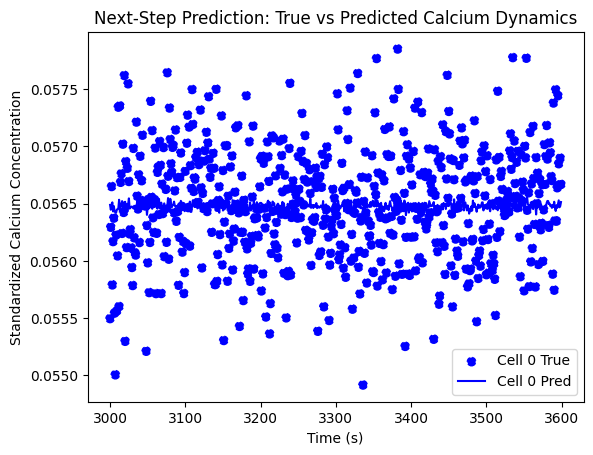

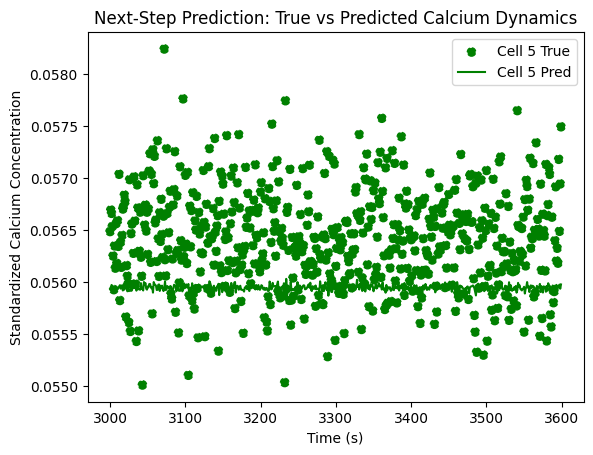

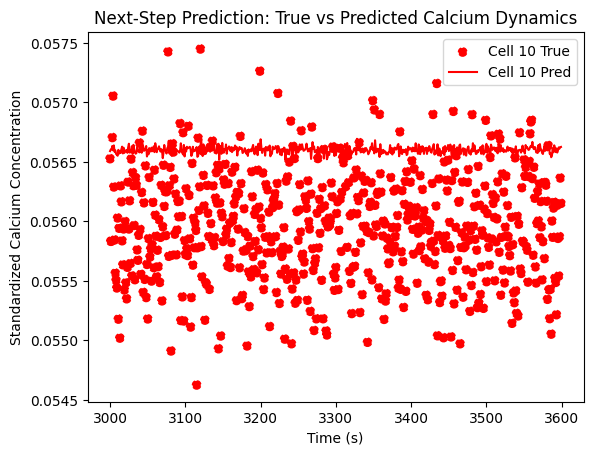

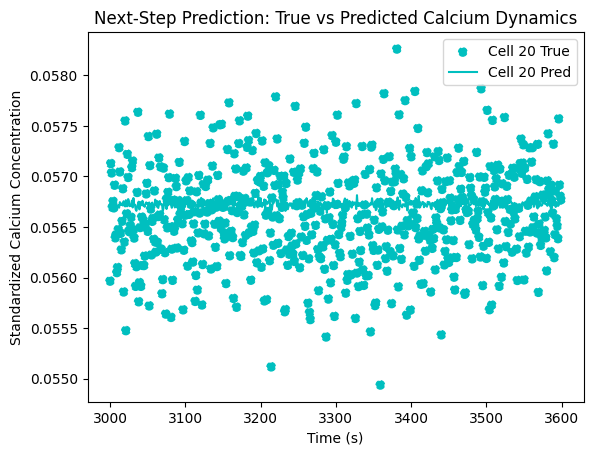

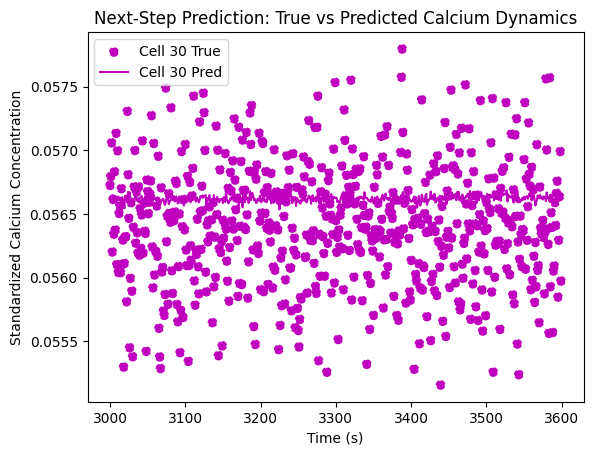

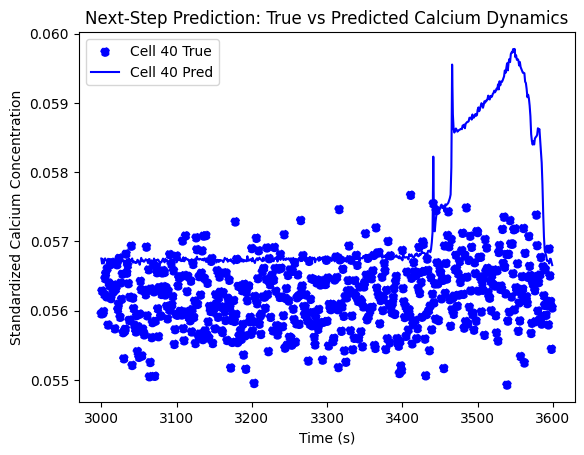

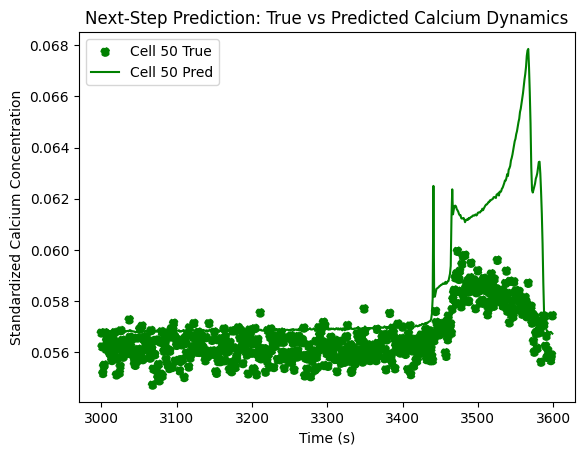

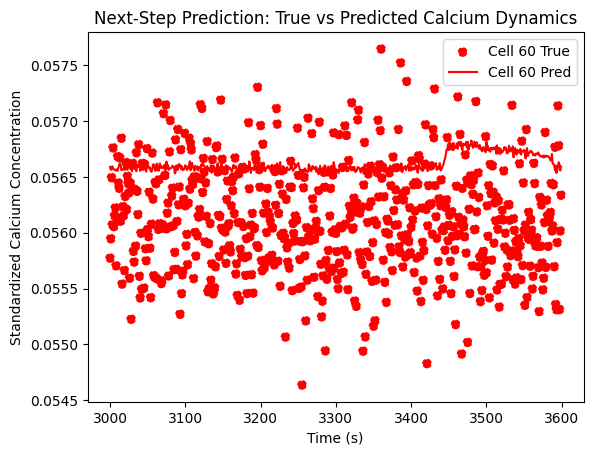

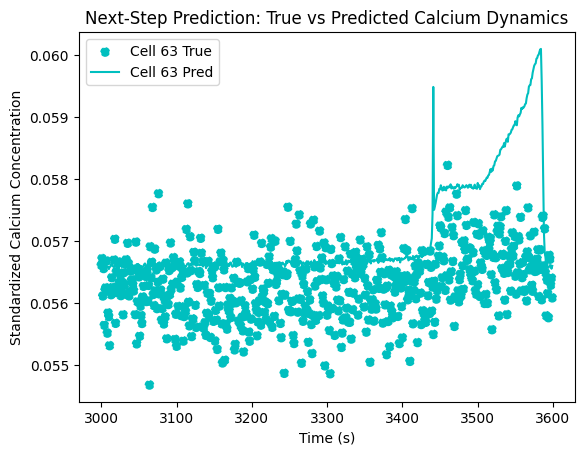

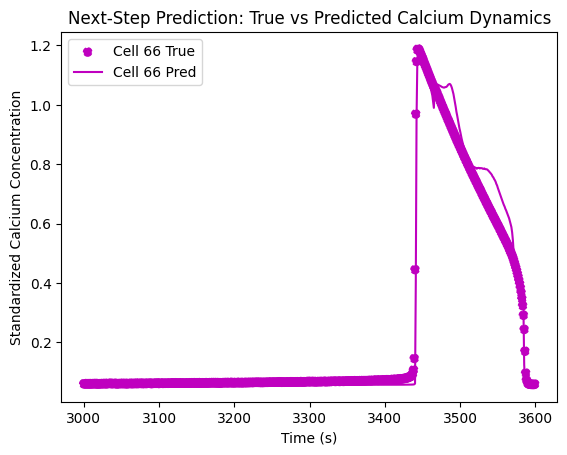

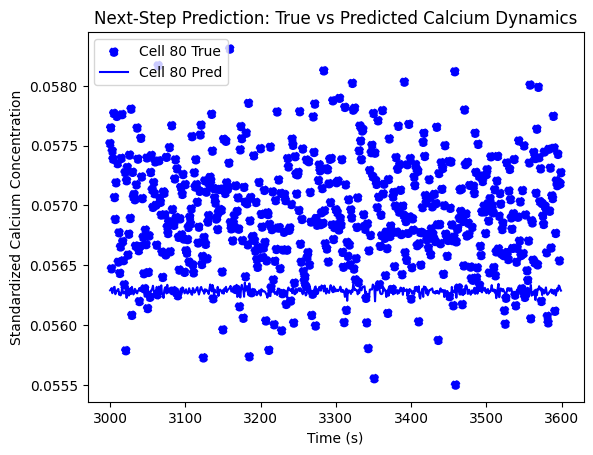

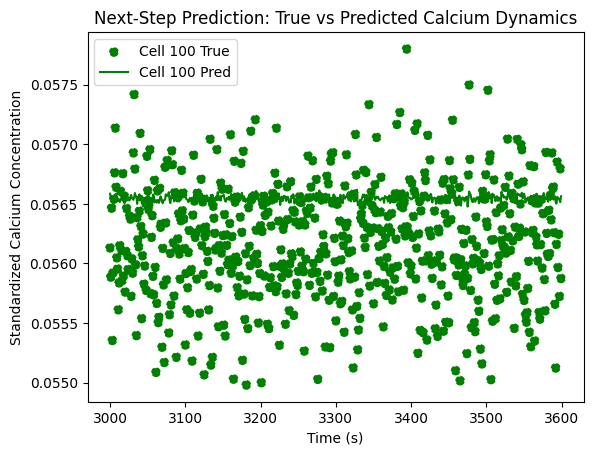

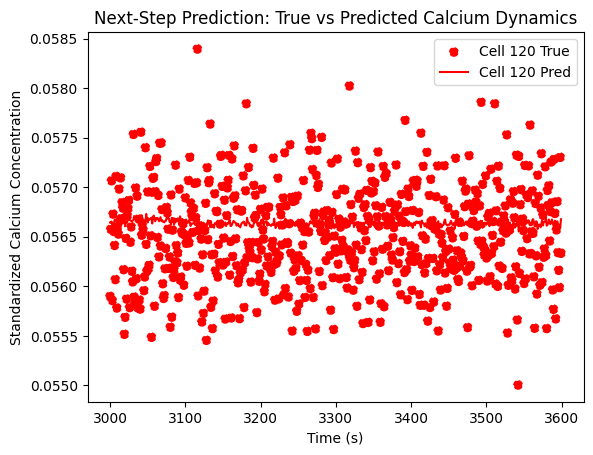

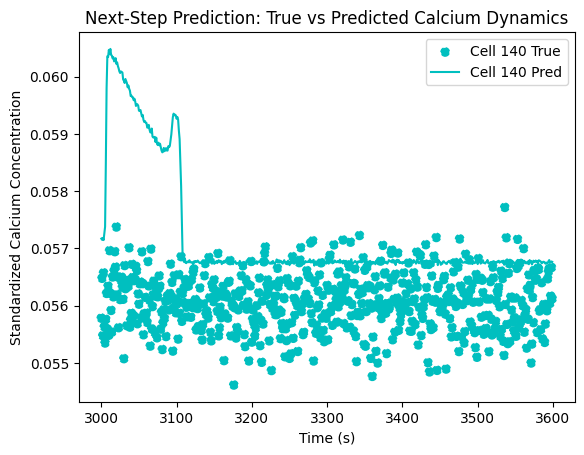

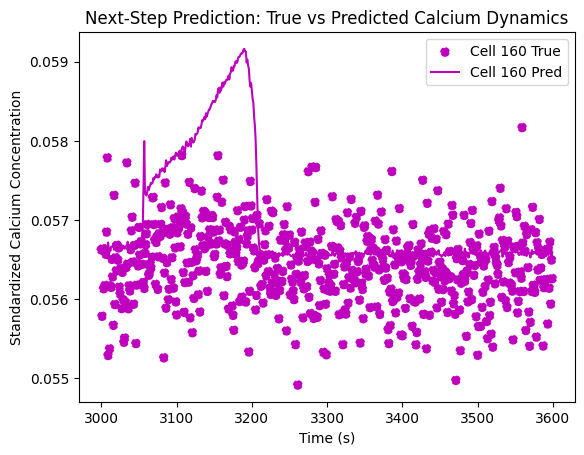

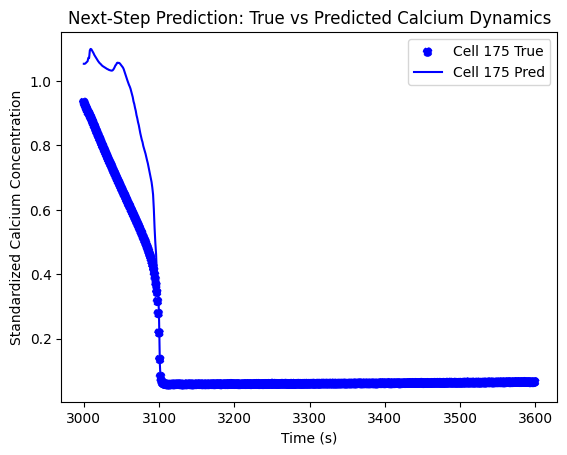

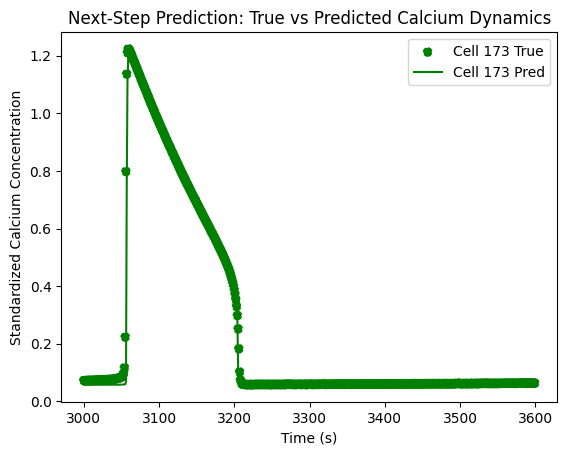

In [47]:
# Plot results for a few example cells
timepoints_test = time_points2[T_train:]

# Cell indices for all cells
cell_indices = [0, 5, 10, 20, 30, 40, 50, 60, 63, 66, 80, 100, 120, 140, 160, 175, 173 ]  #Example cell indices
colors = ['b', 'g', 'r', 'c', 'm']
for i in cell_indices:
    plt.scatter(timepoints_test, truths_arr[i, :], label=f'Cell {i} True', color=colors[cell_indices.index(i) % len(colors)], linestyle='--')
    plt.plot(timepoints_test, preds_arr[i, :], label=f'Cell {i} Pred', color=colors[cell_indices.index(i) % len(colors)], linestyle='-')
    plt.xlabel('Time (s)')
    plt.ylabel('Standardized Calcium Concentration')
    plt.title('Next-Step Prediction: True vs Predicted Calcium Dynamics')
    plt.legend()
    plt.show()